In [1]:
import time
start_time = time.time()

In [2]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from MultiTimeframeCandleManager import MultiTimeframeCandleManager
from datetime import datetime, timedelta
import time
from collections import deque
import numpy as np
import copy
import tensorflow as tf
from tqdm import tqdm
import random
from save_and_load import *
from Candle import Candle
import matplotlib.pyplot as plt

candles = obj_load("NQ_1")
len(candles)

loading NQ_1


250000

In [3]:
num_actions = 3

In [4]:

lrelu = tf.keras.layers.LeakyReLU(0.05)


chart_m15 = tf.keras.layers.Input(shape = (60,4))
chart_m5 = tf.keras.layers.Input(shape = (60,4))
chart_m1 = tf.keras.layers.Input(shape = (60,4))

pdas = tf.keras.layers.Input(shape = (3*3+3*3+1+12*5+5*3,))

current_position = tf.keras.layers.Input(shape = (3,))

minutes = tf.keras.layers.Input(shape = (1,))
minutes_embed = tf.keras.layers.Embedding(input_dim=60*24, output_dim=8)(minutes)
minutes_embed_flat = tf.keras.layers.Flatten()(minutes_embed)

f15 = tf.keras.layers.Flatten()(chart_m15)
f5 = tf.keras.layers.Flatten()(chart_m5)
f1 = tf.keras.layers.Flatten()(chart_m1)

pdas_repeated = tf.keras.layers.Lambda(
lambda inputs: tf.repeat(tf.expand_dims(inputs, axis = 1), repeats=60, axis=1)
)(pdas)

concatenated_m5_at = tf.keras.layers.Concatenate(axis=-1)([chart_m5, pdas_repeated])
m5_at = tf.keras.layers.Dense(256)(concatenated_m5_at)
m5_at = lrelu(m5_at)
m5_at = tf.keras.layers.Dense(128)(m5_at)
m5_at = lrelu(m5_at)
m5_at = tf.keras.layers.Dense(64)(m5_at)
m5_at = lrelu(m5_at)
m5_at = tf.keras.layers.LSTM(128)(m5_at)

concatenated_m1_at = tf.keras.layers.Concatenate(axis=-1)([chart_m1, pdas_repeated])
m1_at = tf.keras.layers.Dense(256)(concatenated_m1_at)
m1_at = lrelu(m1_at)
m1_at = tf.keras.layers.Dense(128)(m1_at)
m1_at = lrelu(m1_at)
m1_at = tf.keras.layers.Dense(64)(m1_at)
m1_at = lrelu(m1_at)
m1_at = tf.keras.layers.LSTM(128)(m1_at)


#c = tf.keras.layers.Concatenate()([f15, f5, f1, pdas, minutes_embed_flat, current_position, scaled_open_profit])
c = tf.keras.layers.Concatenate()([f15, f5, f1, pdas, minutes_embed_flat, current_position, m1_at, m5_at])

d = tf.keras.layers.Dense(4096)(c)
d = lrelu(d)
d = tf.keras.layers.Dense(4096)(d)
d = lrelu(d)
d = tf.keras.layers.Dense(2048)(d)
d = lrelu(d)
d = tf.keras.layers.Dense(1024)(d)
d = lrelu(d)


value = tf.keras.layers.Dense(1, activation="linear")(d)
advantage = tf.keras.layers.Dense(num_actions, activation="linear")(d)

q_values = tf.keras.layers.Lambda(
lambda inputs: inputs[0] + (inputs[1] - tf.reduce_mean(inputs[1], axis=1, keepdims=True))
)([value, advantage])

outputs = tf.keras.layers.Activation('linear', dtype='float32')(q_values)

model = tf.keras.Model(inputs = [chart_m15, chart_m5, chart_m1, pdas, minutes, current_position], outputs = outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 94)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 60, 4)]      0           []                               
                                                                                                  
 lambda (Lambda)                (None, 60, 94)       0           ['input_4[0][0]']                
                                                                                                  
 concatenate_1 (Concatenate)    (None, 60, 98)       0           ['input_3[0][0]',                
                                                                  'lambda[0][0]']             

In [5]:
model.load_weights("model.weights.h5")

In [6]:

def relative (value, center, r):
        return (value - center) / r

def ret_to_scaled_inputs(ret):

    midnight_open, midnight_opening_range_high,midnight_opening_range_low, pdas, current_close, current_time, charts = ret


    center = (midnight_opening_range_high + midnight_opening_range_low) / 2
    r = max(0.0001,(midnight_opening_range_high - midnight_opening_range_low) / 2)

    pda_rel = []
    pda_rel.append(relative(midnight_open, center, r))
    for pda in pdas[0:9+9+15]:
        pda_rel.append(relative(pda, center, r))
    for index in range(9+9+15,9+9+15+5*12):
        ## highs lows are like this [h, h_taken, l, l_taken]
        ## the bools should not be scaled
        if (index - 9+9+15) % 2 == 0:
            pda_rel.append(relative(pdas[index], center, r))
        else:
            pda_rel.append(pdas[index])

    pda_np = np.array(pda_rel)

    current_minutes = current_time.hour * 60 + current_time.minute

    charts_array = []
    for candlesticks in charts:
        charts_array.append([])
        for candle in candlesticks:
            o = relative(candle.o, center, r)
            h = relative(candle.h, center, r)
            l = relative(candle.l, center, r)
            c = relative(candle.c, center, r)
            charts_array[-1].append([o,h,l,c])

    m15_np = np.array(charts_array[0])
    m5_np = np.array(charts_array[1])
    m1_np = np.array(charts_array[2])

    return [m15_np, m5_np, m1_np, pda_np, current_minutes]


# In[11]:


class Order:
    def __init__(self, limit, stop, tp, direction):
        self.entry = limit
        self.tp = tp
        self.sl = stop
        self.direction = direction

class Position:
    def __init__(self, entry, stop, tp, direction):
        self.entry = entry
        self.tp = tp
        self.sl = stop
        self.direction = direction


In [7]:
def step(index):

        global current_position, current_order, slm, m, outputs, all_candles, cmm, equity, equity_L
    
        ret = m.push_m1_candle(candles[index])
        midnight_open, midnight_opening_range_high,midnight_opening_range_low, pdas, current_close, current_time, charts = ret
        center = (midnight_opening_range_high + midnight_opening_range_low) / 2
        r = max(0.0001, (midnight_opening_range_high - midnight_opening_range_low) / 2)



        current_candle_m1 = charts[2][-1]
        #### check tp before filling order so that the same m1 candle will not trigger tp - it is not sure if the candle hit first limit and later tp or reve3rse
        if current_position.direction == 1:
            if current_candle_m1.h >= current_position.tp:
                pnl = (current_position.tp - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)
        if current_position.direction == -1:
            if current_candle_m1.l <= current_position.tp:
                pnl = (current_position.tp - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)

        #### check order
        if current_order != None:
            if  current_order.direction == 1:
                if current_candle_m1.l < current_order.entry:
                    current_position = Position(current_order.entry, current_order.sl, current_order.tp, current_order.direction)
                    #print("fill long order:",current_order.entry, current_order.sl, current_order.tp)
                    equity -= cmm
                    current_order = None
        if current_order != None:
            if  current_order.direction == -1:
                if current_candle_m1.h > current_order.entry:
                    current_position = Position(current_order.entry, current_order.sl, current_order.tp, current_order.direction)
                    #print("fill short order:",current_order.entry, current_order.sl, current_order.tp)
                    equity -= cmm
                    current_order = None

        #### check sl
        if current_position.direction == 1:
            if current_candle_m1.l <= current_position.sl:
                pnl = (current_position.sl - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)
        if current_position.direction == -1:
            if current_candle_m1.h >= current_position.sl:
                pnl = (current_position.sl - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)




        if(len(m.ndogs) == 5 and len(m.fps) == 3 and len(m.opening_range_gaps) == 3 and len(m.asia_highs_lows) == 3 and len(m.london_highs_lows) == 3 and len(m.ny_am_highs_lows) == 3 and len(m.ny_lunch_highs_lows) == 3 and len(m.ny_pm_highs_lows) == 3):


            open_profit = (current_close - current_position.entry) * current_position.direction

            scaled_entry_diff  =  0
            scaled_sl_diff  =  0
            if(current_position.direction != 0):
                scaled_entry_diff = (current_close - current_position.entry) / r
                scaled_sl_diff = (current_close - current_position.sl) / r

            state = ret_to_scaled_inputs(ret) + [np.array([current_position.direction, scaled_entry_diff, scaled_sl_diff])]
            m15_np, m5_np, m1_np, pda_np, current_minutes, pos_info = state

            equity_L.append(equity+open_profit)
            all_candles.append(charts[2][-1])


            if True:#current_minutes >= 9*60+29 and current_minutes < 16*60:
                output = inference_step(
                    tf.expand_dims(m15_np, 0),
                    tf.expand_dims(m5_np, 0),
                    tf.expand_dims(m1_np, 0),
                    tf.expand_dims(pda_np, 0),
                    tf.expand_dims(current_minutes, 0),
                    tf.expand_dims(pos_info, 0)
                )

                last_action = np.argmax(output)
                #last_action = np.argmax([output[0][0], output[0][1]])
                outputs.append(output[0])
            else:
                last_action = 2


            avg_candle_range = np.mean([ i.h - i.l for i in list(charts[2])[55:60]])

            if(last_action == 2 and current_position.direction != 0):
                equity += open_profit
                current_position = Position(0,0,0,0)
                #print("close position:", open_profit)

            if(last_action == 0 and current_position.direction == 1):
                equity += open_profit
                current_position = Position(0,0,0,0)

            if(last_action == 0 and current_position.direction == 0):
                last_candle_low = charts[2][-2].l
                if ( last_candle_low < current_close ):
                    last_candle_low = None

                pdas = m.normal_pdas ## (low, high)

                ## ignore pdas with low below close
                pdas_filtered = []
                for pda in pdas:
                        if(pda[0] > current_close):
                            pdas_filtered.append(pda)
                ### sort
                sorted_by_high = sorted(pdas_filtered, key = lambda x:x[1])
                sorted_by_low = sorted(pdas_filtered, key = lambda x:x[0])

                if(len(pdas_filtered) > 0):

                    ### entry is lowest i can get or immediate rebalance
                    entry = sorted_by_low[0][0]
                    if(last_candle_low != None):
                        entry = min(entry, last_candle_low)


                    sl = entry + avg_candle_range * slm
                    tp = entry  -  abs(entry-sl) * 1000


                    current_order = Order(entry, sl, tp, -1)
                    #print("set short order:",entry,sl,tp)



            if(last_action == 1 and current_position.direction == -1):
                equity += open_profit
                current_position = Position(0,0,0,0)

            if(last_action == 1 and current_position.direction == 0):
                last_candle_high = charts[2][-2].h
                if ( last_candle_high > current_close ):
                    last_candle_high = None
                pdas = m.normal_pdas ## (low, high)

                ## ignore pdas with low below close
                pdas_filtered = []
                for pda in pdas:
                        if(pda[1] < current_close):
                            pdas_filtered.append(pda)
                ### sort
                sorted_by_high = sorted(pdas_filtered, key = lambda x:x[1], reverse=True)
                sorted_by_low = sorted(pdas_filtered, key = lambda x:x[0], reverse=True)

                if(len(pdas_filtered) > 0):
                    ### entry is lowest i can get or immediate rebalance
                    entry = sorted_by_high[0][1]
                    if(last_candle_high != None):
                        entry = max(entry, last_candle_high)

                    sl = entry - avg_candle_range * slm
                    tp = entry  +  abs(entry-sl) * 1000

                    current_order = Order(entry, sl, tp, 1)
                    #print("set long order:",entry,sl,tp)



In [8]:
m = MultiTimeframeCandleManager()

slm = 1.5#1.5

current_position = Position(0,0,0,0)
current_order = None

equity = 0
equity_L = [0]

outputs = []
all_candles = []

cmm = 0.5

@tf.function()
def inference_step(m15_np, m5_np, m1_np, pda_np, current_minutes, pos_info):
    return model([
        m15_np,
        m5_np,
        m1_np,
        pda_np,
        current_minutes,
        pos_info,
    ])



for index in tqdm(range(len(candles))):
    step(index)
    if( index % 100 == 0 ):
        print(equity_L[-1])

print(equity_L[-1])

  2%|█▏                                                                       | 4086/250000 [00:00<00:12, 19905.23it/s]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-14.80000000000291
-14.500000000003638
-26.625000000003638
-29.42500000000655
-29.97500000000582


  2%|█▊                                                                         | 6086/250000 [00:18<16:46, 242.22it/s]

-16.22500000000582
-57.02500000000873
-51.375000000007276
-53.40000000000873
-53.40000000000873
-68.77500000000873
-92.27500000000873
-97.52500000000873


  3%|██                                                                         | 6878/250000 [00:30<28:14, 143.50it/s]

-84.22500000000946
-91.47500000000946
-94.825000000008
-96.02500000000873
-105.87500000001091
-111.75000000001455
-111.75000000001455


  3%|██▎                                                                        | 7537/250000 [00:39<36:48, 109.77it/s]

-111.75000000001455
-112.87500000001455
-128.30000000001746
-116.17500000001746


  3%|██▍                                                                         | 7961/250000 [00:45<41:05, 98.19it/s]

-113.1750000000211
-96.52500000001965
-109.97500000002037


  3%|██▌                                                                         | 8244/250000 [00:48<42:57, 93.79it/s]

-129.7500000000182
-139.60000000002037


  3%|██▌                                                                         | 8437/250000 [00:51<44:25, 90.64it/s]

-131.97500000002037


  3%|██▌                                                                         | 8571/250000 [00:53<45:44, 87.95it/s]

-129.47500000002037


  3%|██▋                                                                         | 8666/250000 [00:54<46:05, 87.27it/s]

-135.97500000002037


  4%|██▋                                                                         | 8783/250000 [00:56<51:41, 77.78it/s]

-135.97500000002037


  4%|██▋                                                                         | 8911/250000 [00:58<53:40, 74.85it/s]

-135.97500000002037


  4%|██▋                                                                       | 9010/250000 [01:00<1:13:02, 54.99it/s]

-127.97500000002037


  4%|██▋                                                                       | 9103/250000 [01:05<5:23:55, 12.39it/s]

-128.25000000002183


  4%|██▋                                                                       | 9205/250000 [01:09<1:27:54, 45.65it/s]

-148.35000000002037


  4%|██▊                                                                       | 9304/250000 [01:10<1:15:23, 53.21it/s]

-56.10000000002037


  4%|██▊                                                                       | 9406/250000 [01:13<1:15:36, 53.04it/s]

-57.60000000002037


  4%|██▊                                                                       | 9504/250000 [01:14<1:24:43, 47.31it/s]

-68.92500000001746


  4%|██▊                                                                       | 9609/250000 [01:17<1:20:42, 49.64it/s]

-79.02500000001601


  4%|██▊                                                                       | 9706/250000 [01:19<1:43:06, 38.84it/s]

-92.27500000001601


  4%|██▉                                                                       | 9805/250000 [01:21<1:10:51, 56.50it/s]

-106.62500000001819


  4%|██▉                                                                       | 9906/250000 [01:23<1:10:36, 56.68it/s]

-108.32500000001892


  4%|██▉                                                                      | 10010/250000 [01:25<1:14:18, 53.83it/s]

-123.75000000001819


  4%|██▉                                                                      | 10105/250000 [01:27<1:33:14, 42.88it/s]

-133.72500000002037


  4%|██▉                                                                      | 10209/250000 [01:29<1:26:10, 46.38it/s]

-137.72500000002037


  4%|███                                                                      | 10309/250000 [01:31<1:06:42, 59.89it/s]

-137.72500000002037


  4%|███                                                                        | 10412/250000 [01:32<54:45, 72.92it/s]

-137.72500000002037


  4%|███                                                                      | 10506/250000 [01:34<1:11:39, 55.70it/s]

-137.72500000002037


  4%|███▏                                                                       | 10608/250000 [01:35<55:23, 72.04it/s]

-135.72500000002037


  4%|███▏                                                                       | 10707/250000 [01:37<48:17, 82.59it/s]

-135.72500000002037


  4%|███▏                                                                     | 10812/250000 [01:38<1:01:21, 64.97it/s]

-134.47500000002037


  4%|███▎                                                                       | 10906/250000 [01:40<49:13, 80.96it/s]

-140.22500000002037


  4%|███▎                                                                       | 11009/250000 [01:41<50:59, 78.12it/s]

-140.22500000002037


  4%|███▎                                                                       | 11113/250000 [01:42<53:27, 74.47it/s]

-140.22500000002037


  4%|███▎                                                                       | 11212/250000 [01:44<51:41, 76.99it/s]

-140.22500000002037


  5%|███▍                                                                       | 11311/250000 [01:45<56:05, 70.93it/s]

-133.47500000002037


  5%|███▍                                                                       | 11413/250000 [01:47<58:53, 67.52it/s]

-137.82500000002256


  5%|███▍                                                                       | 11510/250000 [01:48<58:59, 67.38it/s]

-151.5500000000211


  5%|███▍                                                                     | 11606/250000 [01:50<1:08:15, 58.21it/s]

-155.62500000002183


  5%|███▌                                                                       | 11706/250000 [01:51<54:46, 72.50it/s]

-155.62500000002183


  5%|███▍                                                                     | 11808/250000 [01:53<1:07:57, 58.42it/s]

-155.62500000002183


  5%|███▌                                                                       | 11913/250000 [01:54<56:09, 70.67it/s]

-162.12500000002183


  5%|███▌                                                                       | 12015/250000 [01:56<51:01, 77.74it/s]

-162.12500000002183


  5%|███▌                                                                     | 12109/250000 [01:57<1:05:37, 60.41it/s]

-158.87500000002183


  5%|███▋                                                                       | 12211/250000 [01:59<48:59, 80.90it/s]

-172.75000000002183


  5%|███▋                                                                       | 12306/250000 [02:00<55:27, 71.43it/s]

-226.82500000002256


  5%|███▌                                                                     | 12411/250000 [02:02<1:01:13, 64.67it/s]

-232.45000000001892


  5%|███▊                                                                       | 12510/250000 [02:03<57:13, 69.16it/s]

-222.80000000001746


  5%|███▊                                                                       | 12609/250000 [02:04<55:37, 71.12it/s]

-249.07500000001528


  5%|███▋                                                                     | 12708/250000 [02:06<1:04:38, 61.19it/s]

-245.95000000001528


  5%|███▊                                                                       | 12812/250000 [02:07<54:19, 72.77it/s]

-237.45000000001528


  5%|███▊                                                                     | 12908/250000 [02:09<1:04:30, 61.26it/s]

-237.45000000001528


  5%|███▉                                                                       | 13013/250000 [02:10<59:14, 66.67it/s]

-242.95000000001528


  5%|███▉                                                                       | 13114/250000 [02:12<52:13, 75.60it/s]

-256.72500000001673


  5%|███▉                                                                       | 13207/250000 [02:13<55:12, 71.49it/s]

-271.650000000016


  5%|███▉                                                                       | 13310/250000 [02:15<54:19, 72.61it/s]

-239.525000000016


  5%|███▉                                                                     | 13410/250000 [02:16<1:14:03, 53.24it/s]

-248.525000000016


  5%|███▉                                                                     | 13504/250000 [02:19<2:00:19, 32.76it/s]

-269.85000000001673


  5%|███▉                                                                     | 13608/250000 [02:21<1:27:30, 45.03it/s]

-321.57500000001164


  5%|████                                                                     | 13706/250000 [02:23<1:11:30, 55.07it/s]

-324.20000000001164


  6%|████                                                                     | 13813/250000 [02:25<1:09:42, 56.47it/s]

-364.07500000001164


  6%|████▏                                                                      | 13907/250000 [02:26<55:18, 71.15it/s]

-366.4750000000131


  6%|████                                                                     | 14006/250000 [02:28<1:07:29, 58.28it/s]

-368.9750000000131


  6%|████                                                                     | 14105/250000 [02:30<1:08:48, 57.14it/s]

-369.32500000001164


  6%|████▏                                                                    | 14212/250000 [02:32<1:08:17, 57.54it/s]

-369.32500000001164


  6%|████▎                                                                      | 14310/250000 [02:33<52:02, 75.49it/s]

-369.32500000001164


  6%|████▎                                                                      | 14405/250000 [02:35<54:52, 71.56it/s]

-365.95000000001164


  6%|████▏                                                                    | 14511/250000 [02:36<1:01:53, 63.41it/s]

-387.950000000008


  6%|████▍                                                                      | 14612/250000 [02:37<50:29, 77.69it/s]

-426.90000000000873


  6%|████▎                                                                    | 14709/250000 [02:39<1:07:37, 57.99it/s]

-440.6750000000102


  6%|████▍                                                                      | 14813/250000 [02:41<50:28, 77.65it/s]

-458.85000000000946


  6%|████▎                                                                    | 14910/250000 [02:42<1:01:07, 64.10it/s]

-483.2500000000109


  6%|████▌                                                                      | 15013/250000 [02:43<52:11, 75.04it/s]

-532.4250000000102


  6%|████▍                                                                    | 15107/250000 [02:45<1:01:32, 63.61it/s]

-537.9250000000102


  6%|████▍                                                                    | 15205/250000 [02:46<1:01:41, 63.44it/s]

-547.0250000000124


  6%|████▍                                                                    | 15306/250000 [02:48<1:06:35, 58.74it/s]

-538.4500000000116


  6%|████▍                                                                    | 15406/250000 [02:50<1:07:46, 57.69it/s]

-548.9000000000124


  6%|████▋                                                                      | 15508/250000 [02:52<56:20, 69.37it/s]

-559.0000000000109


  6%|████▋                                                                      | 15607/250000 [02:53<55:33, 70.32it/s]

-572.0250000000087


  6%|████▌                                                                    | 15712/250000 [02:55<1:02:17, 62.68it/s]

-609.5250000000051


  6%|████▋                                                                      | 15807/250000 [02:56<50:32, 77.22it/s]

-613.1500000000051


  6%|████▊                                                                      | 15910/250000 [02:58<51:36, 75.60it/s]

-595.4000000000051


  6%|████▋                                                                    | 16009/250000 [02:59<1:07:43, 57.58it/s]

-618.1500000000051


  6%|████▋                                                                    | 16106/250000 [03:01<1:06:57, 58.22it/s]

-674.4250000000029


  6%|████▊                                                                      | 16206/250000 [03:02<55:55, 69.68it/s]

-672.9000000000015


  7%|████▉                                                                      | 16312/250000 [03:04<59:55, 64.99it/s]

-663.875


  7%|████▉                                                                      | 16409/250000 [03:05<53:37, 72.59it/s]

-663.875


  7%|████▉                                                                      | 16508/250000 [03:06<49:57, 77.89it/s]

-667.625


  7%|████▉                                                                      | 16611/250000 [03:08<58:45, 66.20it/s]

-660.125


  7%|████▉                                                                    | 16708/250000 [03:09<1:02:33, 62.15it/s]

-660.125


  7%|█████                                                                      | 16813/250000 [03:11<53:51, 72.17it/s]

-658.0999999999985


  7%|█████                                                                      | 16911/250000 [03:12<57:08, 67.98it/s]

-664.1499999999978


  7%|████▉                                                                    | 17007/250000 [03:14<1:02:31, 62.11it/s]

-672.7499999999964


  7%|████▉                                                                    | 17108/250000 [03:16<1:09:16, 56.03it/s]

-680.3499999999949


  7%|█████                                                                    | 17206/250000 [03:18<1:12:43, 53.35it/s]

-677.3499999999949


  7%|█████                                                                    | 17308/250000 [03:19<1:15:14, 51.54it/s]

-671.5999999999949


  7%|█████                                                                    | 17407/250000 [03:21<1:05:59, 58.74it/s]

-636.4499999999935


  7%|█████                                                                    | 17507/250000 [03:23<1:15:44, 51.16it/s]

-625.2749999999942


  7%|█████▏                                                                   | 17606/250000 [03:25<1:24:12, 46.00it/s]

-616.7999999999956


  7%|█████▏                                                                   | 17709/250000 [03:27<1:16:01, 50.92it/s]

-609.7999999999956


  7%|█████▏                                                                   | 17808/250000 [03:29<1:00:25, 64.04it/s]

-589.5499999999956


  7%|█████▎                                                                     | 17911/250000 [03:30<55:31, 69.66it/s]

-589.0499999999956


  7%|█████▎                                                                   | 18012/250000 [03:32<1:17:43, 49.75it/s]

-592.2249999999949


  7%|█████▎                                                                   | 18109/250000 [03:34<1:20:43, 47.87it/s]

-592.4749999999949


  7%|█████▎                                                                   | 18206/250000 [03:37<1:34:15, 40.99it/s]

-595.9749999999949


  7%|█████▎                                                                   | 18308/250000 [03:39<1:23:59, 45.98it/s]

-595.9749999999949


  7%|█████▍                                                                   | 18408/250000 [03:41<1:30:20, 42.73it/s]

-600.5249999999942


  7%|█████▍                                                                   | 18511/250000 [03:43<1:09:00, 55.91it/s]

-603.2499999999927


  7%|█████▍                                                                   | 18610/250000 [03:45<1:12:41, 53.05it/s]

-592.2499999999927


  7%|█████▌                                                                     | 18713/250000 [03:47<53:41, 71.79it/s]

-627.9749999999913


  8%|█████▋                                                                     | 18807/250000 [03:48<57:42, 66.76it/s]

-604.9749999999913


  8%|█████▌                                                                   | 18906/250000 [03:50<1:07:17, 57.24it/s]

-623.9499999999898


  8%|█████▋                                                                     | 19010/250000 [03:52<52:14, 73.69it/s]

-621.5249999999905


  8%|█████▌                                                                   | 19106/250000 [03:53<1:03:32, 60.56it/s]

-621.5249999999905


  8%|█████▌                                                                   | 19205/250000 [03:55<1:05:39, 58.58it/s]

-627.424999999992


  8%|█████▊                                                                     | 19313/250000 [03:57<57:47, 66.53it/s]

-629.6499999999905


  8%|█████▊                                                                     | 19408/250000 [03:58<52:18, 73.48it/s]

-626.1499999999905


  8%|█████▊                                                                     | 19509/250000 [04:00<59:11, 64.90it/s]

-618.3999999999905


  8%|█████▉                                                                     | 19612/250000 [04:01<52:48, 72.71it/s]

-619.6499999999905


  8%|█████▊                                                                   | 19712/250000 [04:03<1:03:58, 59.99it/s]

-619.6499999999905


  8%|█████▉                                                                     | 19814/250000 [04:04<51:14, 74.86it/s]

-629.5749999999862


  8%|█████▊                                                                   | 19910/250000 [04:05<1:01:24, 62.45it/s]

-640.224999999984


  8%|█████▊                                                                   | 20011/250000 [04:07<1:04:44, 59.21it/s]

-657.849999999984


  8%|██████                                                                     | 20110/250000 [04:09<51:56, 73.77it/s]

-671.2999999999847


  8%|█████▉                                                                   | 20211/250000 [04:10<1:01:37, 62.15it/s]

-660.1999999999862


  8%|█████▉                                                                   | 20310/250000 [04:12<1:06:29, 57.57it/s]

-653.8249999999862


  8%|██████                                                                     | 20378/250000 [04:13<47:37, 80.36it/s]

KeyboardInterrupt



0 -618.0249999999869


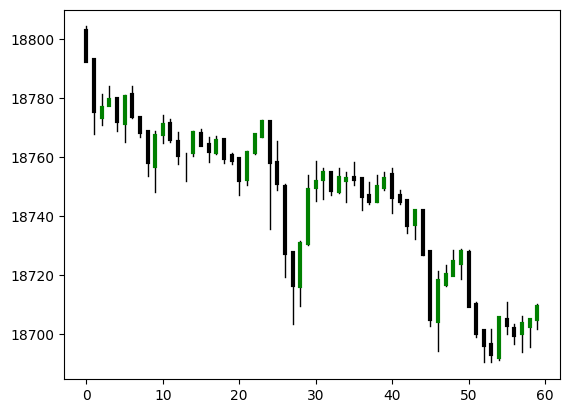

In [9]:
def plot_candles(candles):
    for index in range(len(candles)):
        candle = candles[index]
        c = "green" if candle.c > candle.o else "black"
        plt.plot([index, index], [candle.l, candle.h], linewidth=1, color = "black")
        plt.plot([index, index], [candle.c, candle.o], linewidth=3, color = c)
index+=1
step(index)
plot_candles(m.m1_candles)
if(current_position.direction != 0):
    plt.axhline(current_position.entry, color = "g" if current_position.direction == 1 else "r")
    plt.axhline(current_position.sl, color = "orange")
if(current_order != None):
    plt.axhline(current_order.entry, color = "g" if current_order.direction == 1 else "r")
    plt.axhline(current_order.sl, color = "orange")
print(current_position.direction, equity_L[-1])

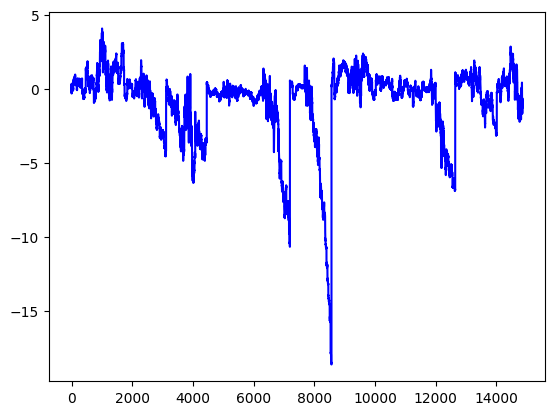

In [10]:
plt.plot([x[1]-x[0] for x in outputs], color="b")

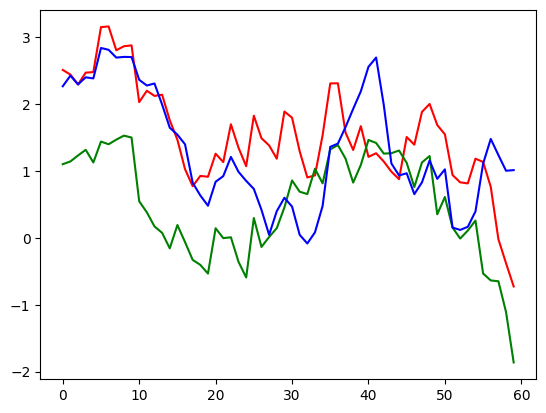

In [11]:
plt.plot([x[0] for x in outputs[-60:]], color="r")
plt.plot([x[1] for x in outputs[-60:]], color="g")
plt.plot([x[2] for x in outputs[-60:]], color="b")

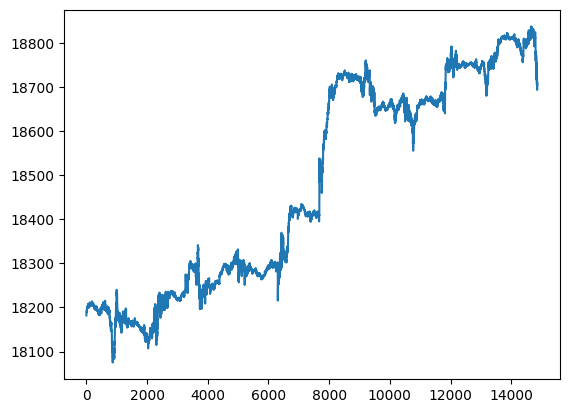

In [12]:
plt.plot([x.c for x in all_candles])

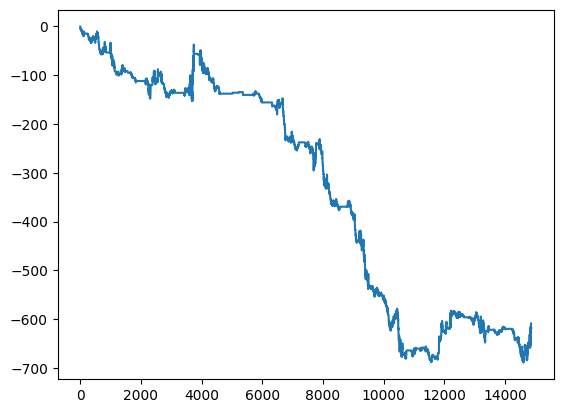

In [13]:
plt.plot(equity_L)

In [14]:
exit()